### Imported Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import lightgbm as lgbm
import matplotlib
import multiprocessing
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

### Feature Extraction Functions

In [2]:
def mad(data):
    return np.mean(np.absolute(data - np.mean(data)))

def import_beta(df):
    df = df.merge(pd.read_csv("all_times.csv"), how='left').fillna(1)
    return df#.drop(['spread'], axis=1).drop(['dom'], axis=1)
    
def compute_wap(df):
    return (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) \
          /(df['bid_size1'] + df['ask_size1'])

def compute_wap2(df):
    return (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) \
           /(df['bid_size2'] + df['ask_size2'])

def compute_dom(df):
    dom = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2']) \
            + (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])
    return dom

def compute_dom_diff(df):
    dom_diff = abs((df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2']) \
            - (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2']))
    return dom_diff

def fill_seconds(df):
    df = df.reset_index(drop=True)
    index_range = pd.Index(range(600), name='seconds_in_bucket')
    df = df.set_index('seconds_in_bucket').reindex(index_range)
    
    # Forward fill & back fill seconds
    df = df.ffill().reset_index()
    return df.bfill().iloc[:600]

def target_encoding(df):
    enc = np.repeat(np.nan, df.shape[0])
    kf = KFold(n_splits = 10, shuffle=True,random_state = 0)
    for idx_1, idx_2 in kf.split(df):
        tmean = df.iloc[idx_1].groupby('stock_id')['target_realized_volatility'].mean()
        enc[idx_2] = df['stock_id'].iloc[idx_2].map(tmean)
    df['target_mean_enc'] = enc
    return df

def generate_feature_seconds(features, df, feats, seconds=[300], overlap=1):
    if overlap:
        for second in seconds:
            res = pd.DataFrame(
                df.query(f'{seconds[0]-second} <= seconds_in_bucket < {seconds[0]}')
                .groupby(['time_id']).agg(feats)
            ).reset_index()
            res.columns = ['_'.join(feat).rstrip('_') for feat in res.columns]
            res = res.add_suffix('_' + str(second))
            features = pd.merge(
                features, res, 
                how='left', 
                left_on='time_id', 
                right_on=f'time_id_{second}'
            )
            features = features.drop([f'time_id_{second}'], axis=1)  
    else:
        for i, second in enumerate(sorted(seconds)):
            last_second = 0 if not i else seconds[i-1]
            res = pd.DataFrame(
                df.query(f'{last_second} <= seconds_in_bucket < {second}')
                .groupby(['time_id']).agg(feats)
            ).reset_index()
            res.columns = ['_'.join(feat).rstrip('_') for feat in res.columns]
            res = res.add_suffix('_' + str(second))
            features = pd.merge(
                features, res, 
                how='left', 
                left_on='time_id', 
                right_on=f'time_id_{second}'
            )
            features = features.drop([f'time_id_{second}'], axis=1)
    return features

def generate_target(df, target, second=300):
    features = pd.DataFrame(
        df.query(f'seconds_in_bucket >= {second}')
        .groupby(['time_id']).agg(target)
    ).reset_index()
    features.columns = ['_'.join(feat).rstrip('_') for feat in features.columns]
    return features

def calc_slope(df):
    v0 = (df['bid_size1']+df['ask_size1'])/2
    p0 = (df['bid_price1']+df['ask_price1'])/2
    slope_bid = ((df['bid_size1']/v0)-1)/abs((df['bid_price1']/p0)-1)+(
                (df['bid_size2']/df['bid_size1'])-1)/abs((df['bid_price2']/df['bid_price1'])-1)
    slope_ask = ((df['ask_size1']/v0)-1)/abs((df['ask_price1']/p0)-1)+(
                (df['ask_size2']/df['ask_size1'])-1)/abs((df['ask_price2']/df['ask_price1'])-1)
    return (slope_bid+slope_ask)/2, abs(slope_bid-slope_ask)


def calc_dispersion(df):
    bspread = df['bid_price1'] - df['bid_price2']
    aspread = df['ask_price2'] - df['ask_price1']
    bmid = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price1']
    bmid2 = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price2']
    amid = df['ask_price1'] - (df['bid_price1'] + df['ask_price1'])/2
    amid2 = df['ask_price2'] - (df['bid_price1'] + df['ask_price1'])/2
    bdisp = (df['bid_size1']*bmid + df['bid_size2']*bspread)/(df['bid_size1']+df['bid_size2'])
    bdisp2 = (df['bid_size1']*bmid + df['bid_size2']*bmid2)/(df['bid_size1']+df['bid_size2'])
    adisp = (df['ask_size1']*amid + df['ask_size2']*aspread)/(df['ask_size1']+df['ask_size2'])      
    adisp2 = (df['ask_size1']*amid + df['ask_size2']*amid2)/(df['ask_size1']+df['ask_size2'])
    return (bdisp + adisp)/2, (bdisp2 + adisp2)/2

def calc_price_impact(df):
    ask = (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])/(df['ask_size1']+df['ask_size2'])
    bid = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2'])/(df['bid_size1']+df['bid_size2'])
    return (df['ask_price1'] - ask)/df['ask_price1'], (df['bid_price1'] - bid)/df['bid_price1']


def calc_ofi(df):
    a = df['bid_size1']*np.where(df['bid_price1'].diff()>=0,1,0)
    b = df['bid_size1'].shift()*np.where(df['bid_price1'].diff()<=0,1,0)
    c = df['ask_size1']*np.where(df['ask_price1'].diff()<=0,1,0)
    d = df['ask_size1'].shift()*np.where(df['ask_price1'].diff()>=0,1,0)
    return a - b - c + d


def calc_tt1(df):
    p1 = df['ask_price1'] * df['ask_size1'] + df['bid_price1'] * df['bid_size1']
    p2 = df['ask_price2'] * df['ask_size2'] + df['bid_price2'] * df['bid_size2']      
    return p2 - p1 

def log_returns(waps):
    return np.log(waps).diff() 

def realized_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2))

def weighted_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2)/log_returns.count())

def quarticity(s):
    return (s.count()/3) * np.sum(s**4)

### Generate Features for First 5 Minutes of Each Stock 

In [3]:
def concat_features(stock_id, df):
    file = f"individual_book_train/stock_{stock_id}.csv"        
    return pd.concat([df, generate_features(file)])

def process_stocks(stock_ids):
    df = pd.DataFrame()
    df = Parallel(n_jobs=-1, verbose=1)(
        delayed(concat_features)(stock_id, df) for stock_id in stock_ids
    )
    # lastly import pre-computed beta coefficients for all stock_ids
    return import_beta(target_encoding(pd.concat(df, ignore_index = True)))

def generate_features(file_path):
    df = pd.read_csv(file_path)
    
    # fill seconds
    df = df.groupby('time_id').apply(fill_seconds).reset_index(drop=True)
    
    # compute waps for first and second ask/bids 
    df['wap'] = compute_wap(df)
    df['wap2'] = compute_wap2(df)
    
    # compute log returns for realized volatility
    df['log_returns'] = df.groupby('time_id')['wap'].apply(log_returns)
    df['log_returns2'] = df.groupby('time_id')['wap2'].apply(log_returns)
    
    # compute difference in waps and price as feature
    df['wap_diff'] = abs(df['wap'] - df['wap2'])
    
    # price difference regularized
    df['price_diff'] = (df['ask_price1'] - df['bid_price1']) \
                        / ((df['ask_price1'] + df['bid_price1'])/2)
    df['price_diff2'] = (df['ask_price2'] - df['bid_price2']) \
                        / ((df['ask_price2'] + df['bid_price2'])/2)
    
    # difference between first and second bid/ask price
    df['bid_diff'] = df['bid_price1'] - df['bid_price2']
    df['ask_diff'] = df['ask_price1'] - df['ask_price2']
    
    # sum of first and second ask sizes and bid sizes
    df['bid_ask_volume'] = (df['ask_size1'] + df['ask_size2']) \
                        + (df['bid_size1'] + df['bid_size2'])
    
    # diff between ask sizes and bid sizes 
    df['bid_ask_volume_diff'] = abs((df['ask_size1'] + df['ask_size2']) \
                                - (df['bid_size1'] + df['bid_size2']))

    # depth of market and difference
    df['dom'] = compute_dom(df)
    df['dom_diff'] = compute_dom_diff(df)
    df['dom_imbalance'] = abs(df['dom'] - df['dom_diff'])
    
    # bid ask spread from lecture/lab
    df["bid_ask_spread1"] = df['ask_price1'] / df['bid_price1'] - 1
    df["bid_ask_spread2"] = df['ask_price2'] / df['bid_price2'] - 1
    df['bid_ask_spread3'] = abs(df['bid_diff'] - df['ask_diff'])
    
    df["slope"], _ = calc_slope(df)
    df["dispersion"], _ = calc_dispersion(df)
    df["price_impact"], _ = calc_price_impact(df)
    df["ofi"] = calc_ofi(df)
    df["turn_over"] = calc_tt1(df)
    
    
    df['target'] =  df.groupby('time_id')['wap'].apply(log_returns)
    
    target_dict = {'target':[realized_volatility]}
    feature_dict = {
        'wap':[np.mean, np.std],#, mad, np.max, np.sum],
        'wap2':[np.mean, np.std],#, mad, np.max, np.sum],
        'log_returns':[realized_volatility, weighted_volatility, 
                       quarticity, np.mean, np.std],
        'log_returns2':[realized_volatility, weighted_volatility, 
                       quarticity, np.mean, np.std],
        'wap_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'price_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'price_diff2':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'ask_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_volume':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_volume_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'dom':[np.mean, np.std],#, mad, np.max, np.sum],
        'dom_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'dom_imbalance':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_spread1':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_spread2':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_spread3':[np.mean, np.std],#, mad, np.max, np.sum],
        #'slope':[np.mean, np.std],#, mad, np.max, np.sum],
        #'dispersion':[np.mean, np.std],#, mad, np.max, np.sum],
        #'price_impact':[np.mean, np.std],#, mad, np.max, np.sum],
        'ofi':[np.mean, np.std],#, mad, np.max, np.sum],
        #'turn_over':[np.mean, np.std]#, mad, np.max, np.sum],
    }
    
    # target realized volatility for next 300 second (5 min window in time_id)
    feature = generate_target(
        df, target=target_dict, 
        second=480  # target volatility is for next 300 second (no overlap)
    )
    
    # obtain features over entire 5 mins or last 2.5 mins..
    feature = generate_feature_seconds(
        feature, df, 
        feats=feature_dict, 
        seconds=[480, 360, 240, 120],  # features generated for each second interval (different widths)
        overlap=0,
    )

    #create stock_id
    feature['stock_id'] = int(file_path.split('/')[1].split('_')[1].split('.')[0])
    feature['time_id'] = feature['time_id'].apply(int)
    
    return feature

## Process Features for All Stocks

In [4]:
all_stocks = process_stocks(pd.read_csv("all_times.csv").stock_id.unique())
all_stocks

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  5.1min finished


,time_id,target_realized_volatility,wap_mean_120,wap_std_120,wap2_mean_120,wap2_std_120,log_returns_realized_volatility_120,log_returns_weighted_volatility_120,log_returns_quarticity_120,log_returns_mean_120,...,bid_ask_spread2_std_480,bid_ask_spread3_mean_480,bid_ask_spread3_std_480,ofi_mean_480,ofi_std_480,stock_id,target_mean_enc,beta,dom,spread
0,5,0.001467,1.002990,0.000985,1.002737,0.001118,0.002011,0.000184,1.140018e-10,1.980775e-05,...,0.000222,0.000337,0.000187,1.216667,50.967737,0,0.001762,1.208072,313.922175,0.000865
1,11,0.000896,0.999868,0.000127,0.999907,0.000143,0.000516,0.000047,5.453540e-13,-2.063757e-06,...,0.000094,0.000194,0.000068,2.583333,31.200146,0,0.001785,1.719756,380.683774,0.000432
2,16,0.000775,1.000200,0.000142,1.000235,0.000270,0.000865,0.000079,5.020985e-12,5.798750e-06,...,0.000314,0.000432,0.000226,-3.204167,60.332100,0,0.001790,7.164047,417.199888,0.000733
3,31,0.000987,1.000203,0.000317,0.999682,0.000336,0.000976,0.000089,2.255101e-11,-1.253992e-05,...,0.000311,0.000282,0.000185,0.754167,42.475417,0,0.001780,6.559597,465.014775,0.000898
4,62,0.001154,0.999719,0.000301,0.999590,0.000381,0.000987,0.000090,1.366586e-11,-4.644492e-06,...,0.000217,0.000290,0.000137,-0.558333,64.607511,0,0.001785,0.680616,332.463664,0.000401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,32751,0.001568,1.000132,0.000329,1.000249,0.000381,0.001196,0.000110,2.000412e-11,3.777283e-06,...,0.000234,0.000269,0.000179,5.258333,84.286769,126,0.002373,0.895436,418.205006,0.000870
428928,32753,0.002532,1.001125,0.000209,1.001207,0.000253,0.000845,0.000077,2.069122e-12,-3.172516e-06,...,0.000242,0.000298,0.000204,3.291667,36.517410,126,0.002373,-1.346971,222.682585,0.000670
428929,32758,0.001176,1.000908,0.000231,1.000679,0.000337,0.000760,0.000070,3.492257e-12,-2.672697e-06,...,0.000233,0.000299,0.000146,10.358333,111.270547,126,0.002376,0.904714,346.025217,0.000754
428930,32763,0.001035,1.001580,0.000371,1.001602,0.000410,0.001829,0.000168,3.112044e-11,7.848200e-06,...,0.000220,0.000281,0.000159,-0.420833,111.965635,126,0.002381,-0.099107,438.588531,0.000526


In [5]:
len(all_stocks[all_stocks['target_realized_volatility']==0])

9

In [6]:
all_stocks = all_stocks[all_stocks['target_realized_volatility']!=0]

### Removing row with zero realized volatility
* Only one row where target_realized_vol = 0
* Corrupts RMSPE and MAPE metric scores
    * Denominator is y_true
    * Added small epsilon to prevent zerodivision
    * Results in very large error if y_true = 0

In [7]:
#all_stocks = all_stocks.drop(index=132867)

### Defining X for LightGBM

* should scale features if regularization?

In [8]:
all_stocks_X = all_stocks.drop(['time_id','target_realized_volatility'], axis=1)  # leave stock id as feature 
#all_stocks_X[:] = MinMaxScaler().fit(all_stocks_X).transform(all_stocks_X)
all_stocks_X

,wap_mean_120,wap_std_120,wap2_mean_120,wap2_std_120,log_returns_realized_volatility_120,log_returns_weighted_volatility_120,log_returns_quarticity_120,log_returns_mean_120,log_returns_std_120,log_returns2_realized_volatility_120,...,bid_ask_spread2_std_480,bid_ask_spread3_mean_480,bid_ask_spread3_std_480,ofi_mean_480,ofi_std_480,stock_id,target_mean_enc,beta,dom,spread
0,1.002990,0.000985,1.002737,0.001118,0.002011,0.000184,1.140018e-10,1.980775e-05,0.000184,0.002612,...,0.000222,0.000337,0.000187,1.216667,50.967737,0,0.001762,1.208072,313.922175,0.000865
1,0.999868,0.000127,0.999907,0.000143,0.000516,0.000047,5.453540e-13,-2.063757e-06,0.000047,0.000947,...,0.000094,0.000194,0.000068,2.583333,31.200146,0,0.001785,1.719756,380.683774,0.000432
2,1.000200,0.000142,1.000235,0.000270,0.000865,0.000079,5.020985e-12,5.798750e-06,0.000079,0.002602,...,0.000314,0.000432,0.000226,-3.204167,60.332100,0,0.001790,7.164047,417.199888,0.000733
3,1.000203,0.000317,0.999682,0.000336,0.000976,0.000089,2.255101e-11,-1.253992e-05,0.000089,0.000990,...,0.000311,0.000282,0.000185,0.754167,42.475417,0,0.001780,6.559597,465.014775,0.000898
4,0.999719,0.000301,0.999590,0.000381,0.000987,0.000090,1.366586e-11,-4.644492e-06,0.000091,0.001326,...,0.000217,0.000290,0.000137,-0.558333,64.607511,0,0.001785,0.680616,332.463664,0.000401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,1.000132,0.000329,1.000249,0.000381,0.001196,0.000110,2.000412e-11,3.777283e-06,0.000110,0.002600,...,0.000234,0.000269,0.000179,5.258333,84.286769,126,0.002373,0.895436,418.205006,0.000870
428928,1.001125,0.000209,1.001207,0.000253,0.000845,0.000077,2.069122e-12,-3.172516e-06,0.000078,0.001677,...,0.000242,0.000298,0.000204,3.291667,36.517410,126,0.002373,-1.346971,222.682585,0.000670
428929,1.000908,0.000231,1.000679,0.000337,0.000760,0.000070,3.492257e-12,-2.672697e-06,0.000070,0.001975,...,0.000233,0.000299,0.000146,10.358333,111.270547,126,0.002376,0.904714,346.025217,0.000754
428930,1.001580,0.000371,1.001602,0.000410,0.001829,0.000168,3.112044e-11,7.848200e-06,0.000168,0.002725,...,0.000220,0.000281,0.000159,-0.420833,111.965635,126,0.002381,-0.099107,438.588531,0.000526


### Defining y for LightGBM

In [9]:
all_stocks_y = all_stocks[['target_realized_volatility', 'stock_id', 'time_id']]
len(all_stocks_y.time_id.unique())

3830

In [10]:
all_stocks_y

,target_realized_volatility,stock_id,time_id
0,0.001467,0,5
1,0.000896,0,11
2,0.000775,0,16
3,0.000987,0,31
4,0.001154,0,62
...,...,...,...
428927,0.001568,126,32751
428928,0.002532,126,32753
428929,0.001176,126,32758
428930,0.001035,126,32763


In [11]:
len(pd.read_csv("all_times.csv").time_id.unique())

3802

Note: Including stock_id and time_id for logging predictions for app (target_realized_volatility is only target)

## Training LightGBM

### Model Helper Functions

In [12]:
EPSILON = 0 #1e-10 set epsilon to zero as removed zero row for realized volatility (ONLY ONE ROW! angryyy )

def compute_importance(model, features, typ='gain'):
    return pd.DataFrame(
        model.feature_importance(importance_type=typ),
        index=features,
        columns=['importance']
    ).sort_values('importance')
    
def rmspe(y_true, y_pred):
    return  np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true + EPSILON))))

def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds), 4), False

### Nested 5-Fold Cross-Validation

In [13]:
%%time
test = pd.DataFrame({'target_realized_volatility':[],'predicted_volatility': [],'time_id':[], 'stock_id':[]})
all_models = []
split_importance = []
gain_importance = []
train_scores = []
inner_k = 5
outer_k = 5

# some params taken from research paper (link @ bottom of notebook)
params = {
    "objective": "regression",
    "metric": "rmse", 
    "boosting_type": "gbdt",
    "feature_fraction": 0.8,  
    "bagging_fraction": 0.8,
    "learning_rate": 0.01,
    "n_jobs": -1,
    "lambda_l1": 2,
    "lambda_l2": 2,
    "num_boost_round":5000,
    "force_col_wise": True,
  }


outer_kfold = KFold(n_splits=outer_k, random_state=0, shuffle=True)
for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_kfold.split(all_stocks_X, all_stocks_y)):
    print('*'*120)
    print("Outer Fold :", outer_fold + 1)
    print('*'*120)

    X_outer_train = all_stocks_X.iloc[outer_train_idx].reset_index(drop=True)
    y_outer_train = all_stocks_y.iloc[outer_train_idx].reset_index(drop=True)
    X_outer_test = all_stocks_X.iloc[outer_test_idx].reset_index(drop=True)
    y_outer_test = all_stocks_y.iloc[outer_test_idx].reset_index(drop=True)
    
    target = np.zeros(len(y_outer_test))
    inner_scores = 0.0
    models = []
    inner_kfold = KFold(n_splits= inner_k, random_state=0, shuffle=True)
    for inner_fold, (inner_train_idx, inner_valid_idx) in enumerate(inner_kfold.split(X_outer_train, y_outer_train)):
        print("\n\t"+"*"*20)
        print(f"\t*  Inner Fold : {inner_fold + 1}  *")
        print("\t"+"*"*20+"\n")
    
        # inner train data and valid data
        X_inner_train = X_outer_train.iloc[inner_train_idx].reset_index(drop=True)
        y_inner_train = y_outer_train.iloc[inner_train_idx].reset_index(drop=True)['target_realized_volatility']
        X_inner_valid = X_outer_train.iloc[inner_valid_idx].reset_index(drop=True)
        y_inner_valid = y_outer_train.iloc[inner_valid_idx].reset_index(drop=True)['target_realized_volatility']
    
        lgbm_train = lgbm.Dataset(
            X_inner_train, 
            y_inner_train, 
            weight = 1 / (np.square(y_inner_train.values)+EPSILON)         # weighting rmspe
        )
        lgbm_valid = lgbm.Dataset(
            X_inner_valid, 
            y_inner_valid, 
            reference = lgbm_train, 
            weight = 1 / (np.square(y_inner_valid.values)+EPSILON)        # weighting rmspe
        )
        # model training
        model = lgbm.train(
            params=params,
            train_set=lgbm_train,
            valid_sets=[lgbm_train, lgbm_valid],       
            feval=feval_RMSPE,
            callbacks=[lgbm.log_evaluation(period=100), lgbm.early_stopping(50)]
        )
        # validation 
        y_inner_pred = model.predict(X_inner_valid, num_iteration=model.best_iteration)
        RMSPE = rmspe(
            y_true=(y_inner_valid.values.flatten()), 
            y_pred=(y_inner_pred)
        )
        
        print("\t"+"*" * 100)
        print(f'\tInner Validation RMSPE: {RMSPE}')
        print("\t"+"*" * 100)

        # keep training validation score
        inner_scores += RMSPE / inner_k
        models.append(model)
        
        # record feature importances by gain and split
        features = list(X_inner_train.columns.values)
        gain_importance.append(compute_importance(model, features, typ='gain'))
        split_importance.append(compute_importance(model, features, typ='split'))
    
    # store all models for prediction in oof evaluation
    all_models.append(models)
    train_scores.append(inner_scores)
    
    # out of fold test set
    for model in all_models[outer_fold]:
        y_outer_pred = model.predict(X_outer_test, num_iteration=model.best_iteration)
        target += y_outer_pred / len(all_models[outer_fold])
        
    y_outer_test = y_outer_test.assign(predicted_volatility = target)
    test = pd.concat([test, y_outer_test]).reset_index(drop=True)

************************************************************************************************************************
Outer Fold : 1
************************************************************************************************************************

	********************
	*  Inner Fold : 1  *
	********************



C:\Users\imgap\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Total Bins 22552
[LightGBM] [Info] Number of data points in the train set: 274510, number of used features: 89
[LightGBM] [Info] Start training from score 0.000189
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's rmse: 0.000397069	training's RMSPE: 0.8971	valid_1's rmse: 0.000233445	valid_1's RMSPE: 1.477
	****************************************************************************************************
	Inner Validation RMSPE: 1.4769635207950345
	****************************************************************************************************

	********************
	*  Inner Fold : 2  *
	********************

[LightGBM] [Info] Total Bins 22551
[LightGBM] [Info] Number of data points in the train set: 274510, number of used features: 89
[LightGBM] [Info] Start training from score 0.000071
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	training's rms

[200]	training's rmse: 0.00011234	training's RMSPE: 0.4011	valid_1's rmse: 0.000320639	valid_1's RMSPE: 0.5449
[300]	training's rmse: 0.000103381	training's RMSPE: 0.3691	valid_1's rmse: 0.000313347	valid_1's RMSPE: 0.5325
[400]	training's rmse: 9.99327e-05	training's RMSPE: 0.3568	valid_1's rmse: 0.000309253	valid_1's RMSPE: 0.5256
Early stopping, best iteration is:
[418]	training's rmse: 9.95517e-05	training's RMSPE: 0.3554	valid_1's rmse: 0.000308569	valid_1's RMSPE: 0.5244
	****************************************************************************************************
	Inner Validation RMSPE: 0.524419866268559
	****************************************************************************************************

	********************
	*  Inner Fold : 2  *
	********************

[LightGBM] [Info] Total Bins 22551
[LightGBM] [Info] Number of data points in the train set: 274510, number of used features: 89
[LightGBM] [Info] Start training from score 0.000076
Training until valida

[LightGBM] [Info] Total Bins 22552
[LightGBM] [Info] Number of data points in the train set: 274511, number of used features: 89
[LightGBM] [Info] Start training from score 0.000187
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.0002205	training's RMSPE: 0.5019	valid_1's rmse: 0.000463971	valid_1's RMSPE: 0.7339
Early stopping, best iteration is:
[60]	training's rmse: 0.000267196	training's RMSPE: 0.6082	valid_1's rmse: 0.000452629	valid_1's RMSPE: 0.7159
	****************************************************************************************************
	Inner Validation RMSPE: 0.7159444352420392
	****************************************************************************************************

	********************
	*  Inner Fold : 2  *
	********************

[LightGBM] [Info] Total Bins 22552
[LightGBM] [Info] Number of data points in the train set: 274511, number of used features: 89
[LightGBM] [Info] Start training from score 0.000206
Tra

### Training Validation Result with 5-fold CV

In [14]:
print(f'Train Result RMSPE: {np.mean(train_scores)}')

Train Result RMSPE: 0.8861347945334724


In [15]:
train_scores

[0.9523736381384099,
 0.8970228580207993,
 0.8446651636214636,
 0.8980421452700623,
 0.8385701676166272]

## NOTE: Problem with using RMSPE when actual value near zero
* Solution: removed single row with zero realized vol

### Testing Result with Nested 5-fold CV (test set is out of fold)

In [16]:
RMSPE = round(rmspe(y_true=test['target_realized_volatility'], y_pred=test['predicted_volatility']), 3)

print(f'Test Result RMSPE: {RMSPE}')

Test Result RMSPE: 1.165


## Mean Absolute Percentage Error

In [17]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true+1e-10))) 

print(f"Test Result MAPE: {mape(test['target_realized_volatility'], test['predicted_volatility'])}")

Test Result MAPE: 0.663406328042158


### Write Predictions to CSV

In [18]:
test = test.astype({'time_id': int, 'stock_id': int})
test.to_csv("lightgbm_goss_predict.csv")
test

,target_realized_volatility,predicted_volatility,time_id,stock_id
0,0.001014,0.000143,147,0
1,0.001171,0.000265,309,0
2,0.003706,0.000302,326,0
3,0.000519,0.000200,381,0
4,0.000515,0.000322,424,0
...,...,...,...,...
428918,0.002472,0.000582,32690,126
428919,0.001261,0.000561,32692,126
428920,0.001056,0.000411,32709,126
428921,0.002854,0.000442,32712,126


## Model Feature Importance

In [19]:
import seaborn as sns

def plot_importance(importance, title='', save_to_file=None, top=None):    
    importance = importance.sort_values(
        ['Importance'], ascending=False
    )[:top]#.sort_values(['Importance'])
    
    plt.figure(figsize=(10, 8))
    #importance.plot.barh(ax=ax)
    sns.barplot(x="Importance", y="Features", data=importance.sort_values(by="Importance",ascending=False))
    
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_to_file:
        plt.savefig(save_to_file)
    plt.show()
    plt.close()

def compute_mean_importance(importance):
    res = importance[0].copy()
    res['Importance'] = np.mean(np.array(
        [df['importance'].values for df in importance]
    ), axis=0)
    
    res = res.drop(['importance'], axis=1)
    
    # reformat for plot
    return pd.DataFrame(
        {'Features':[f for f in res.index], 
         'Importance': res['Importance']}
    ).reset_index(drop=True)


### Plotting Importance by Gain & Split

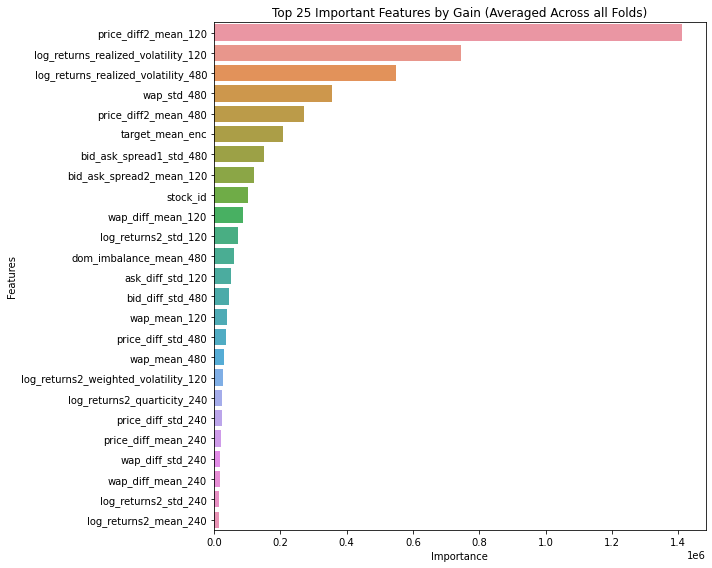

,Features,Importance
0,wap2_mean_360,0.000000e+00
1,bid_diff_mean_360,0.000000e+00
2,bid_diff_std_360,0.000000e+00
3,ask_diff_mean_360,0.000000e+00
4,ask_diff_std_360,0.000000e+00
...,...,...
168,price_diff2_mean_480,2.714585e+05
169,wap_std_480,3.548095e+05
170,log_returns_realized_volatility_480,5.495919e+05
171,log_returns_realized_volatility_120,7.459258e+05


In [20]:
mean_gain = compute_mean_importance(gain_importance)

plot_importance(mean_gain, title='Top 25 Important Features by Gain (Averaged Across all Folds)', top=25)

mean_gain

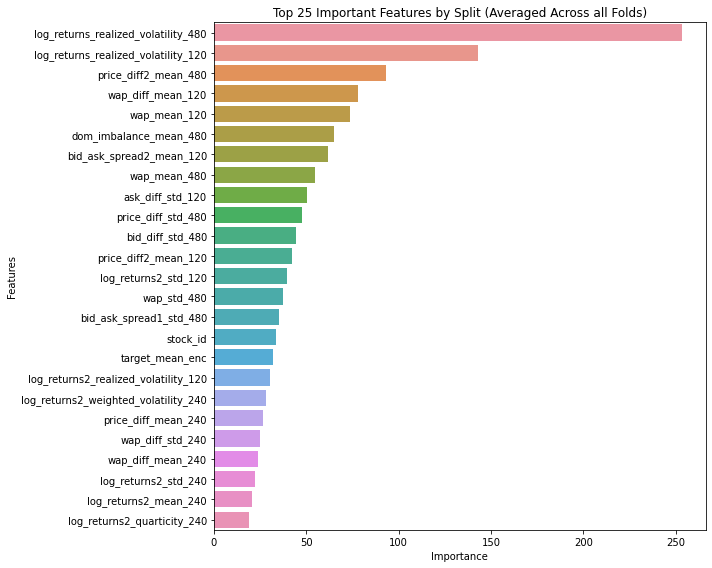

,Features,Importance
0,wap2_mean_360,0.00
1,bid_diff_mean_360,0.00
2,bid_diff_std_360,0.00
3,ask_diff_mean_360,0.00
4,ask_diff_std_360,0.00
...,...,...
168,wap_mean_120,73.60
169,wap_diff_mean_120,77.80
170,price_diff2_mean_480,93.12
171,log_returns_realized_volatility_120,142.76


In [21]:
mean_split = compute_mean_importance(split_importance)
plot_importance(mean_split, title='Top 25 Important Features by Split (Averaged Across all Folds)', top=25)

mean_split

### Reference Paper: LightGBM Based Optiver Realized Volatility Prediction
#### Link:  https://ieeexplore-ieee-org.ezproxy.library.sydney.edu.au/document/9543438

### Notes to Self:

 Parameters:importance_type (string, optional (default="split")) – 
 
* If “split”, result contains numbers of times the feature is used in a model. 
 
* If “gain”, result contains total gains of splits which use the feature.
 
 Returns:   result – Array with feature importances.
 Return type:   numpy array`